In [2]:
# Librerías estándar

import sys
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Scikit-Learn
from sklearn.model_selection import (
    train_test_split,
    StratifiedKFold,
    TimeSeriesSplit,
    GroupKFold,  # <--- NUEVO: Para evitar leakage de grupos
    cross_val_score
)
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score
import lightgbm as lgb

# Configuración visual
plt.rcParams['figure.figsize'] = (10, 6)
sns.set_style("whitegrid")

# Configuración de rutas (para cargar utilidades)
sys.path.append(os.path.abspath('../../'))
from recursos.utils import load_data


# 🚀 Sesión 04: Validación Robusta y Estrategias de Cross-Validation

## 📑 Índice
1.  [El Problema de la Aleatoriedad](#1.-El-Problema-de-la-Aleatoriedad) 🎲
2.  [Stratified K-Fold (La Solución al Desbalance)](#2.-Stratified-K-Fold-(La-Solución-al-Desbalance)) ⚖️
3.  [Group K-Fold (El Problema de la Identidad)](#3.-Group-K-Fold-(El-Problema-de-la-Identidad)) 🆔
4.  [Time Series Split (El Futuro no Predice el Pasado)](#4.-Time-Series-Split-(El-Futuro-no-Predice-el-Pasado)) ⏳
5.  [Micro-Desafío](#5.-🧠-Micro-Desafío) 🧠

## 💼 Caso de Negocio: Credit Scoring & Retail
**Contexto:**
1.  **Credit Scoring:** Tenemos un dataset desbalanceado (pocos morosos). Si hacemos un split aleatorio, podríamos quedarnos sin morosos en el set de validación.
2.  **Fraude/Transaccional:** Un mismo cliente hace muchas compras. Si mezclamos sus compras en Train y Test, el modelo memoriza al cliente ("Juan siempre paga") en lugar de aprender patrones de fraude.
3.  **Retail (Ventas):** Queremos predecir ventas futuras. El tiempo es lineal, no podemos barajar los días.

**Tu Misión:** Implementar estrategias de validación que simulen la realidad productiva y eviten el **Data Leakage**.

## 🎯 Objetivos de Aprendizaje
1.  **Diagnosticar:** Entender por qué `train_test_split` es insuficiente.
2.  **Corregir Desbalance:** Usar `StratifiedKFold`.
3.  **Evitar Leakage de Identidad:** Usar `GroupKFold`.
4.  **Respetar el Tiempo:** Usar `TimeSeriesSplit`.

### 📂 Diccionario de Datos (Credit Scoring)
Estamos trabajando con un dataset real de **Riesgo de Crédito**.
El objetivo es predecir si un cliente caerá en incumplimiento de pago (`target_y = 1`).

**Variables Clave:**
*   `target_y`: **Variable Objetivo**. 1 = Cliente Incumplidor (Bad), 0 = Cliente Cumplidor (Good).
*   `RevolvingUtilizationOfUnsecuredLines`: Porcentaje de límite de crédito usado.
*   `age`: Edad del prestatario.
*   `DebtRatio`: Ratio de deuda mensual sobre ingreso mensual.
*   `MonthlyIncome`: Ingreso mensual.
*   `NumberOfOpenCreditLinesAndLoans`: Número de préstamos abiertos.

In [3]:
# Constantes
TARGET_COL = 'target_y'
COLS_TO_DROP = [TARGET_COL, 'malo_sf_inicio', 'periodo', 'Unnamed: 0']

# 1. Cargar Datos de Crédito
df = load_data('credit_scoring.csv')

# 2. Preprocesamiento Básico (Solo para el ejemplo de validación)
# Eliminamos columnas irrelevantes
X = df.drop([c for c in COLS_TO_DROP if c in df.columns], axis=1)
y = df[TARGET_COL]

# Nos quedamos solo con numéricas para simplificar este demo
X = X.select_dtypes(include=['int64', 'float64'])
X = X.fillna(X.median())

print(f"Dimensiones: {X.shape}")
print(f"Tasa de Default Global: {y.mean():.4%}")


Dimensiones: (7180, 21)
Tasa de Default Global: 24.4847%


## 1. El Problema de la Aleatoriedad 🎲

### ¿Por qué `train_test_split` no es suficiente?
Si ejecutamos un split aleatorio varias veces, obtendremos resultados diferentes. En datasets pequeños o desbalanceados, esta varianza puede ser peligrosa.

Vamos a demostrarlo empíricamente:

Ejecutando 1000 experimentos aleatorios...


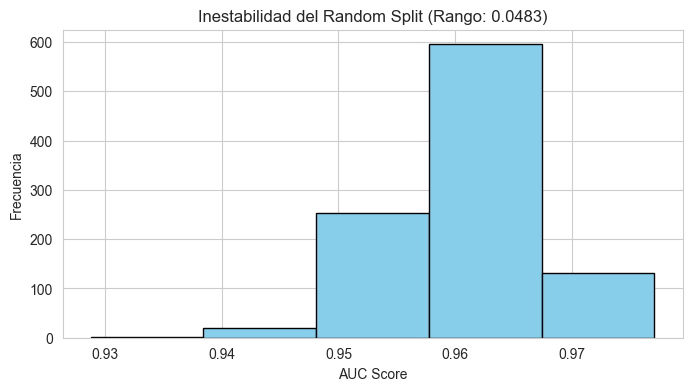

In [8]:
# Experimento: Ejecutar 10 splits aleatorios y ver la varianza del AUC
aucs = []

print("Ejecutando 1000 experimentos aleatorios...")
for i in range(1000):
    # Split aleatorio simple
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=i  # Cambiamos la semilla cada vez
    )

    # Modelo rápido
    model = lgb.LGBMClassifier(n_estimators=50, verbose=-1)
    model.fit(X_train, y_train)

    # Evaluar
    y_pred = model.predict_proba(X_test)[:, 1]
    auc = roc_auc_score(y_test, y_pred)
    aucs.append(auc)
    #print(f"Iteración {i+1}: AUC = {auc:.4f}")

# Visualizar la inestabilidad
plt.figure(figsize=(8, 4))
plt.hist(aucs, bins=5, color='skyblue', edgecolor='black')
plt.title(
    f"Inestabilidad del Random Split (Rango: {max(aucs) - min(aucs):.4f})")
plt.xlabel("AUC Score")
plt.ylabel("Frecuencia")
plt.show()


## 2. Stratified K-Fold (La Solución al Desbalance) ⚖️

### ¿Cómo funciona?
En lugar de un solo split, dividimos los datos en **K partes (folds)**.
*   Entrenamos en K-1 partes.
*   Validamos en la parte restante.
*   **Stratified:** Asegura que cada fold tenga el mismo % de morosos que el dataset original.

Esto nos da una estimación mucho más robusta del rendimiento real.

Iniciando Cross-Validation...

AUC Scores por Fold: [0.97567668 0.97294584 0.97890284 0.9747581  0.98004385]
AUC Promedio: 0.9765 +/- 0.0026


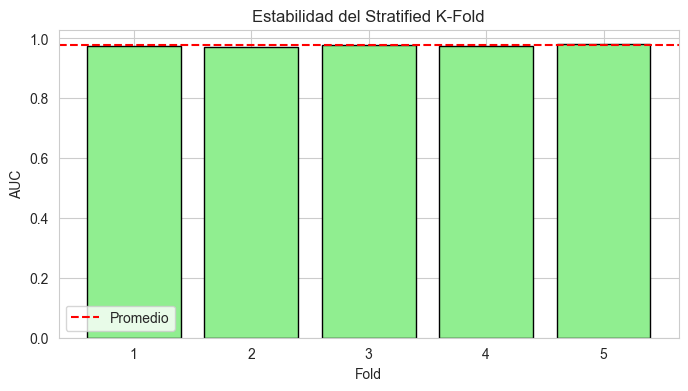

In [18]:
# Configurar StratifiedKFold 100 mil (10 veces) - 4 millones (10 veces)
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Modelo Base
model = lgb.LGBMClassifier(n_estimators=100, verbose=-1)

# Cross Validation
print("Iniciando Cross-Validation...")
cv_scores = cross_val_score(model, X, y, cv=skf, scoring='roc_auc')

# Resultados
print(f"\nAUC Scores por Fold: {cv_scores}")
print(f"AUC Promedio: {cv_scores.mean():.4f} +/- {cv_scores.std():.4f}")

# Visualización de Scores
plt.figure(figsize=(8, 4))
plt.bar(range(1, 6), cv_scores, color='lightgreen', edgecolor='black')
plt.axhline(cv_scores.mean(), color='red', linestyle='--', label='Promedio')
plt.title("Estabilidad del Stratified K-Fold")
plt.xlabel("Fold")
plt.ylabel("AUC")
plt.legend()
plt.show()


## 3. Group K-Fold (El Problema de la Identidad) 🆔

### ⚠️ Real-World Warning: Data Leakage por Grupos
Imagina que tienes un dataset de **transacciones médicas**.
*   El paciente "Juan Pérez" tiene 10 visitas al médico.
*   Si haces un split aleatorio, 7 visitas de Juan van a Train y 3 a Test.
*   El modelo aprenderá: *"Si es Juan Pérez, tiene diabetes"*.
*   **En Producción:** Llega un paciente NUEVO (María), y el modelo falla porque no sabe generalizar, solo memorizó a Juan.

### La Solución: GroupKFold
Asegura que **todas** las transacciones de un mismo grupo (Paciente, Cliente, Tienda) estén **íntegramente** en Train o en Test. Nunca mezcladas.

Datos de Ejemplo (Nota cómo se repiten los Cliente_ID):
    Feature  Cliente_ID
0  0.022222           0
1 -0.427793           1
2 -0.531817           1
3 -0.117476           1
4  0.222079           2
5 -0.767977           2
6  0.142465           2
7 -0.034652           2
8  1.134339           2
9 -0.104746           3
Fold 1 - Grupos en Test: {4} (¿Intersección con Train?: False)
Fold 2 - Grupos en Test: {1, 3} (¿Intersección con Train?: False)
Fold 3 - Grupos en Test: {0, 2} (¿Intersección con Train?: False)


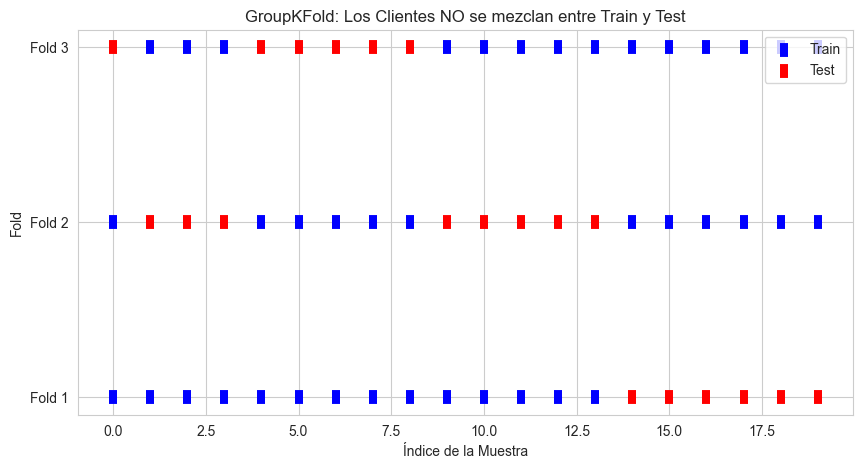

In [12]:
# Simulación de Data con Grupos (Clientes con múltiples préstamos)
np.random.seed(42)
n_samples = 20
n_groups = 5  # Solo 5 clientes únicos

# Generamos datos dummy
groups = np.sort(np.random.randint(0, n_groups, n_samples))
X_dummy = pd.DataFrame(
    {'Feature': np.random.randn(n_samples), 'Cliente_ID': groups})
y_dummy = np.random.randint(0, 2, n_samples)

print("Datos de Ejemplo (Nota cómo se repiten los Cliente_ID):")
print(X_dummy.head(10))

# Visualización de GroupKFold
gkf = GroupKFold(n_splits=3)

plt.figure(figsize=(10, 5))
for i, (train_idx, test_idx) in enumerate(gkf.split(X_dummy, y_dummy, groups=groups)):
    # Visualizar qué índices están en Train y Test
    plt.scatter(train_idx, [i]*len(train_idx), c='blue',
                marker='_', lw=10, label='Train' if i == 0 else "")
    plt.scatter(test_idx, [i]*len(test_idx), c='red',
                marker='_', lw=10, label='Test' if i == 0 else "")

    # Verificar intersección de grupos
    train_groups = set(groups[train_idx])
    test_groups = set(groups[test_idx])
    print(f"Fold {i+1} - Grupos en Test: {test_groups} (¿Intersección con Train?: {not train_groups.isdisjoint(test_groups)})")

plt.title("GroupKFold: Los Clientes NO se mezclan entre Train y Test")
plt.xlabel("Índice de la Muestra")
plt.ylabel("Fold")
plt.legend()
plt.yticks(range(3), [f"Fold {i+1}" for i in range(3)])
plt.show()


### ⚠️ Real-World Warning: La Trampa de la Independencia (IID)
`StratifiedKFold` asume que los datos son **Independientes e Idénticamente Distribuidos (IID)**.
Esto significa que el orden no importa.

**¿Cuándo falla esto?**
*   **Fraude:** Los patrones de fraude cambian mes a mes.
*   **Cobranzas:** La economía afecta la tasa de pago.
*   **Ventas:** La Navidad no se parece a Marzo.

En estos casos, usar K-Fold aleatorio es **HACER TRAMPA**, porque usas información del futuro para predecir el pasado.
Para eso existe **Time Series Split**.

### 🧠 Micro-Desafío: Estabilidad vs Tiempo
Cambia el número de splits (`n_splits`) en el StratifiedKFold a **10**.

1.  ¿Cómo afecta esto a la desviación estándar de los scores? (¿Es más estable o menos?)
2.  ¿Cuánto aumenta el tiempo de ejecución?

> **💡 Pro-Tip:** En la industria, `n_splits=5` es el estándar. Usar 10 es mejor pero más lento. Usar Leave-One-Out (n_splits=N) es teóricamente perfecto pero computacionalmente imposible en Big Data.

## 4. Time Series Split (El Futuro no Predice el Pasado) ⏳

### La Intuición del "Out-of-Time" (OOT)
En negocios, la pregunta más honesta es:
> *"Si entreno con datos hasta el mes pasado, ¿qué tan bien predeciré este mes?"*

No podemos barajar los días. El **Time Series Split** (o Expanding Window) simula este proceso de re-entrenamiento continuo.

*   **Fold 1:** Entreno Ene-Mar -> Pruebo Abril
*   **Fold 2:** Entreno Ene-Abr -> Pruebo Mayo
*   **Fold 3:** Entreno Ene-May -> Pruebo Junio

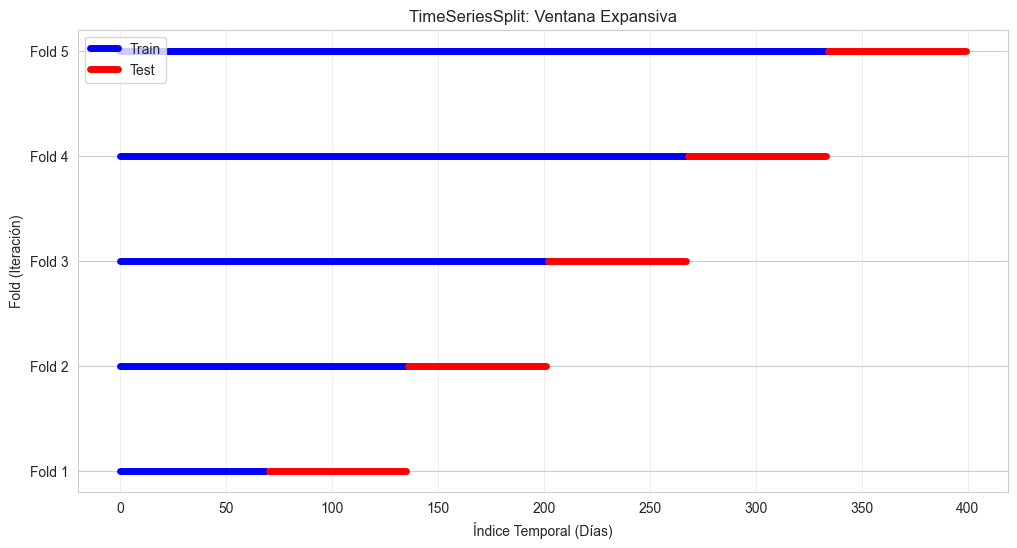

In [7]:
# 1. Cargar Datos de Ventas (Simulación)
try:
    # Intentamos cargar el dataset real si existe
    df_ts = pd.read_csv('../data/DS_Compra.csv')
    if 'Date' not in df_ts.columns:
        # Si no tiene fecha, creamos una dummy
        df_ts['Date'] = pd.date_range(
            start='2023-01-01', periods=len(df_ts), freq='D')
except:
    # Fallback: Crear data dummy temporal
    print("Generando datos sintéticos de series temporales...")
    dates = pd.date_range(start='2023-01-01', periods=1000, freq='D')
    values = np.random.randn(1000).cumsum()
    df_ts = pd.DataFrame({
        'Date': dates,
        'INGRESOS': values,
        'FLAG_COMPRA': (values > 0).astype(int)
    })

df_ts = df_ts.sort_values('Date').reset_index(drop=True)
X_ts = df_ts[['INGRESOS']]
y_ts = df_ts['FLAG_COMPRA']

# 2. Visualización del Split Temporal
tscv = TimeSeriesSplit(n_splits=5)

plt.figure(figsize=(12, 6))
for i, (train_index, test_index) in enumerate(tscv.split(X_ts)):
    # Indices de Train
    plt.plot(train_index, [i] * len(train_index), lw=5,
             c='blue', label='Train' if i == 0 else "")
    # Indices de Test
    plt.plot(test_index, [i] * len(test_index), lw=5,
             c='red', label='Test' if i == 0 else "")

plt.legend(loc='upper left')
plt.title("TimeSeriesSplit: Ventana Expansiva")
plt.xlabel("Índice Temporal (Días)")
plt.ylabel("Fold (Iteración)")
plt.yticks(range(5), [f"Fold {i+1}" for i in range(5)])
plt.grid(True, axis='x', alpha=0.3)
plt.show()


---
## 🏆 Resumen de Logros

| Estrategia | Problema que Resuelve | Cuándo Usarla |
|------------|-----------------------|---------------|
| **StratifiedKFold** | Desbalance de Clases | Default para clasificación (Churn, Default). |
| **GroupKFold** | Data Leakage de Identidad | Múltiples filas por cliente/paciente/tienda. |
| **TimeSeriesSplit** | Data Leakage Temporal | Forecasting, Fraude, Ventas, Stock. |

### 👉 Siguiente Paso
Ahora que confiamos en *cómo* validamos el modelo, necesitamos confiar en *por qué* toma decisiones.
En el siguiente notebook (`02_Explainable_AI_SHAP.ipynb`), usaremos **SHAP** para explicar las predicciones.